Instructions: click restart and run all above. Figures will show once the entire notebook has finished running

In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

# Defining and solving PDE models

This notebook will demonstrate how we can define and solve a PDE model using functions in this package.

## pdeRK function

This package contains the pdeRK function, a versatile PDE solver that can be used to solve any system of PDEs, using an adaptive Runge-Kutta method.

```python
soln, time, solns, times = pdeRK(dxdt, X0, Tmax, deltat, t_eval, killfunc=None, stabilitycheck=False)
```

The function takes the following inputs:
- dxdt: A function that takes list of 1D arrays (one for each species) corresponding to concentrations over space, and returns list of gradient arrays
- X0: list specifying the initial state of the system. Will be used as the input to dxdt on the first time step
- Tmax: timepoint at which to terminate simulation
- deltat: initial timestep (this will be adapted throughout the simulation)
- t_eval: a list of timepoints for which to save the state of the system
- killfunc: an optional kill function that takes the same input as dxdt. Integration will terminate when this function returns True
- stabilitycheck: if True, integration will terminate when the system stabilises (changes by less that 1% per 60 time units). Default is False

The function returns the following outputs:
- soln: final solution 
- time: final time. Will be close to Tmax but not exact due to finite and adaptable time step
- solns: solutions at times specified by t_eval
- times: times corresponding to saved states in solns. Will be close to times specified in t_eval but not exact due to finite and adaptable time step

We can use this function to perform custom simulations by building an appropriate PDE model. In this notebook, we will demonstrate this using the Goehring et al., 2011 PAR model as an example.

In [2]:
from parmodel import pdeRK

## Building a PDE model

The primary input of pdeRK is a PDE model function, which defines the reactions in the model. This must take a single argument, representing the current state of the system (X), and return a single output representing the gradient of chage of the system with respect to time (dXdt). X must take the form of a list, where each entry in the list is a 1D array representing the spatial distribution of one species. This can be any length, depending on how many species there are in the model. Here, as we have two species (A and P), X will be a list of length 2. dXdt will take the same form.

As this particular model contains many parameters, it is useful to build it in class form, specifying parameter values in the init function. This is demonstrated below for the Goehring model, where the function dxdt is built to describe all of the different reactions in the model. We can simulate diffusion (reflective boundaries) with the diffusion function, which takes a single concentration array and the spatial step size as inputs, and calculates diffusion for a single timestep.

In [3]:
from parmodel import diffusion

class Goehring2011:
    def __init__(self, Da=0.28, Dp=0.15, konA=0.00858, koffA=0.0054, konP=0.0474, koffP=0.0073, kPA=2, kAP=0.19,
                 alpha=1, beta=2, xsteps=100, psi=0.174, L=134.6, pA=1.56, pP=1):
     
        # Dosages
        self.pA = pA
        self.pP = pP

        # Diffusion
        self.Da = Da  # input is um2 s-1
        self.Dp = Dp  # um2 s-1

        # Membrane exchange
        self.konA = konA  # um s-1
        self.koffA = koffA  # s-1
        self.konP = konP  # um s-1
        self.koffP = koffP  # s-1

        # Antagonism
        self.kPA = kPA  # um4 s-1
        self.kAP = kAP  # um2 s-1
        self.alpha = alpha
        self.beta = beta

        # Spatial
        self.L = L
        self.xsteps = int(xsteps)
        self.deltax = self.L / xsteps  # um
        self.psi = psi  # um-1

    def dxdt(self, X):
        """
        Function describing time evolution of the model
        X = [A, P], where A and P are arrays of length xsteps, representing cortical aPAR and pPAR concentrations
        
        """
        
        A = X[0]
        P = X[1]
        ac = self.pA - self.psi * np.mean(A)
        pc = self.pP - self.psi * np.mean(P)
        dA = ((self.konA * ac) - (self.koffA * A) - (self.kAP * (P ** self.alpha) * A) + (
                self.Da * diffusion(A, self.deltax)))
        dP = ((self.konP * pc) - (self.koffP * P) - (self.kPA * (A ** self.beta) * P) + (
                self.Dp * diffusion(P, self.deltax)))
        return [dA, dP]
    
model = Goehring2011()

## Specify initial conditions

Simulations must be started from an initial state. There are many possible ways to do this. Here, we will start the system completely polarised with an arbitrary membrane concentration, although there are more systematic ways that we could do this. By starting the simulation from this state, we will test the ability of the model to maintain polarity once given an initial pattern.

In [4]:
def initial_conditions(model):
    A0 = 3 * np.r_[np.ones([model.xsteps // 2]), np.zeros([model.xsteps // 2])]
    P0 = 3 * np.r_[np.zeros([model.xsteps // 2]), np.ones([model.xsteps // 2])] 
    return [A0, P0]

X0 = initial_conditions(model)

<IPython.core.display.Javascript object>


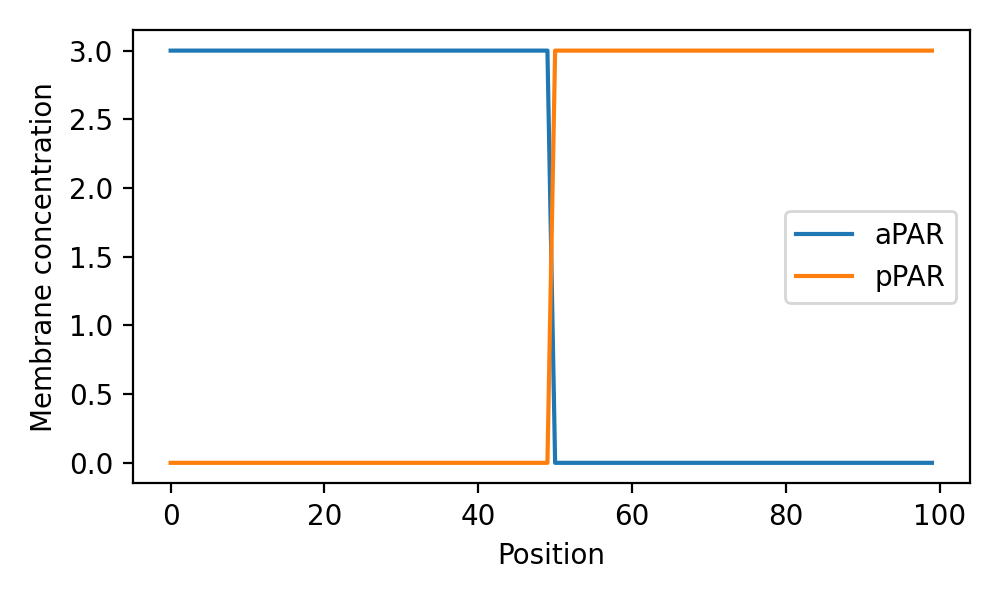

In [5]:
def par_plot(X):
    fig, ax = plt.subplots()
    ax.plot(X[0], label='aPAR')
    ax.plot(X[1], label='pPAR')
    ax.set_xlabel('Position')
    ax.set_ylabel('Membrane concentration')
    ax.legend()
    fig.set_size_inches(5,3)
    fig.tight_layout()
    
par_plot(X0)

## Run PDE simulation

Now that we've set up a model and specified the initial conditions, we can perform a simulation using pdeRK. We also need to specify Tmax, deltat and t_eval. We will run this model for 1000 seconds (~17 mins).

In [6]:
soln, time, solns, times = pdeRK(dxdt=model.dxdt, X0=X0, Tmax=1000, deltat=0.01, t_eval=np.arange(0, 1001, 10))

#### Plot final state

<IPython.core.display.Javascript object>


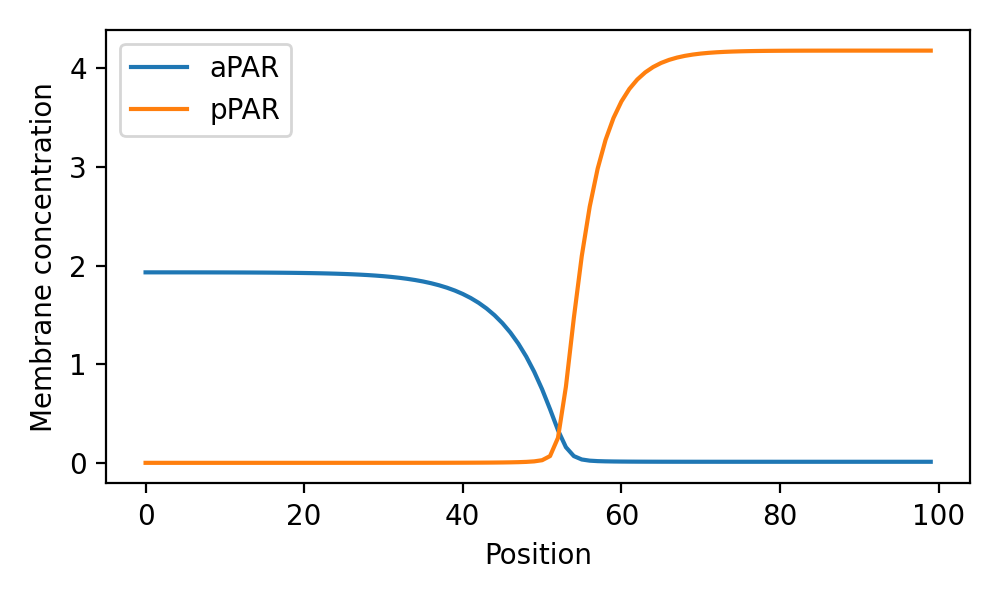

In [7]:
par_plot(soln)

#### Plot time evolution

<IPython.core.display.Javascript object>


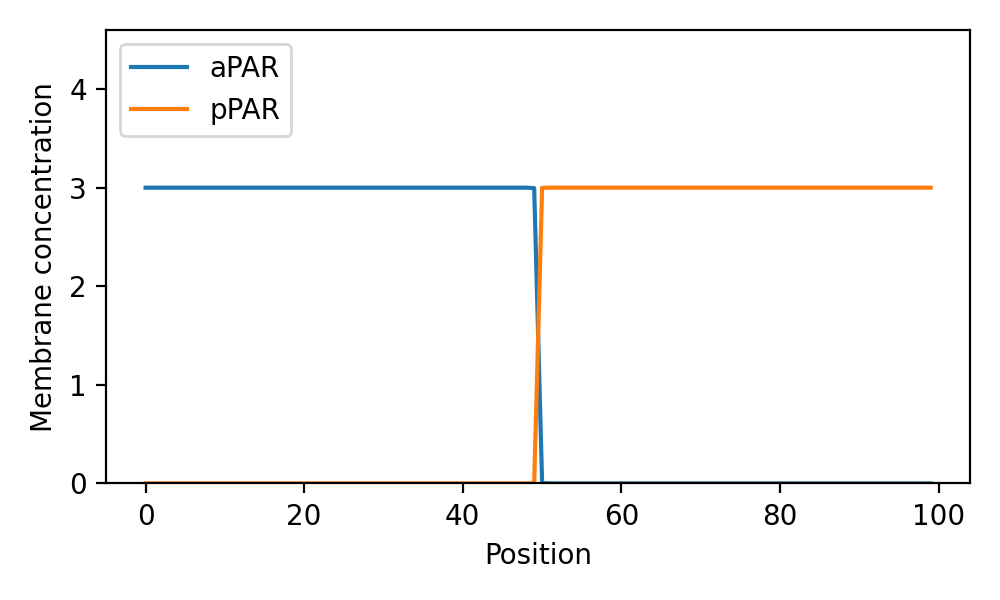

interactive(children=(FloatSlider(value=0.0, description='time', max=1000.2236290490375, step=1.0), Output()),…

In [8]:
import ipywidgets as widgets

def interactive_fig(solns, times):
    fig, ax = plt.subplots()
    ymax = 1.1 * max(np.max(solns[0]), np.max(solns[1]))
    @widgets.interact(time=(0, times[-1], 1))
    def update(time=0):
        ax.clear()
        tpoint = np.argmin(abs(times - time))
        ax.plot(solns[0][tpoint], label='aPAR')
        ax.plot(solns[1][tpoint], label='pPAR')
        ax.set_ylim(0, ymax)
        ax.set_xlabel('Position')
        ax.set_ylabel('Membrane concentration')
        ax.legend(loc='upper left')

    fig.set_size_inches(5,3)
    fig.tight_layout()
    
interactive_fig(solns, times)

We can see that, with the current parameters set, the model is succesfully able to maintain polarity if started from a polarised state.

## Running the PDE with a kill function

In the above example, we speficied simulation time with the Tmax parameter, and ran the model until this time was reached. In some cases it may not be necessary to run a model for the whole time period, and we can save time by terminating the simulation early. 

One way to do this is by providing a kill function to pdeRK, with the killfunc argument.  This function will be evaluated at every iteration, taking the same input as dxdt, and test specific criteria for terminating the simulation. In this example, we will set up a function that detects whether or not the system is polarised, returning False is the system is polarised, and True when polarity is lost (defined as the presence or absence of a cross point in the aPAR and pPAR concentration profiles). This will cause the simulation to terminate early if polarity is lost before Tmax. This way we can quickly test whether a particular model can maintain polarity, without having to run simulations for the full time period.

In [9]:
def killfunc(X):
    """
    Returns True if there is no cross point in the aPAR and pPAR concentration profiles
    
    """
    if sum(X[0] > X[1]) == len(X[0]) or sum(X[0] > X[1]) == 0:
        return True
    return False

This is demonstrated below, using a model with a lower kPA that cannot maintain polarity:

In [10]:
model2 = Goehring2011(kPA=0.5)

soln2, time2, solns2, times2 = pdeRK(dxdt=model2.dxdt, X0=initial_conditions(model2), Tmax=1000, deltat=0.01, 
                                 t_eval=np.arange(0, 1001, 10), killfunc=killfunc)
print(time2)

654.5066535941907


<IPython.core.display.Javascript object>


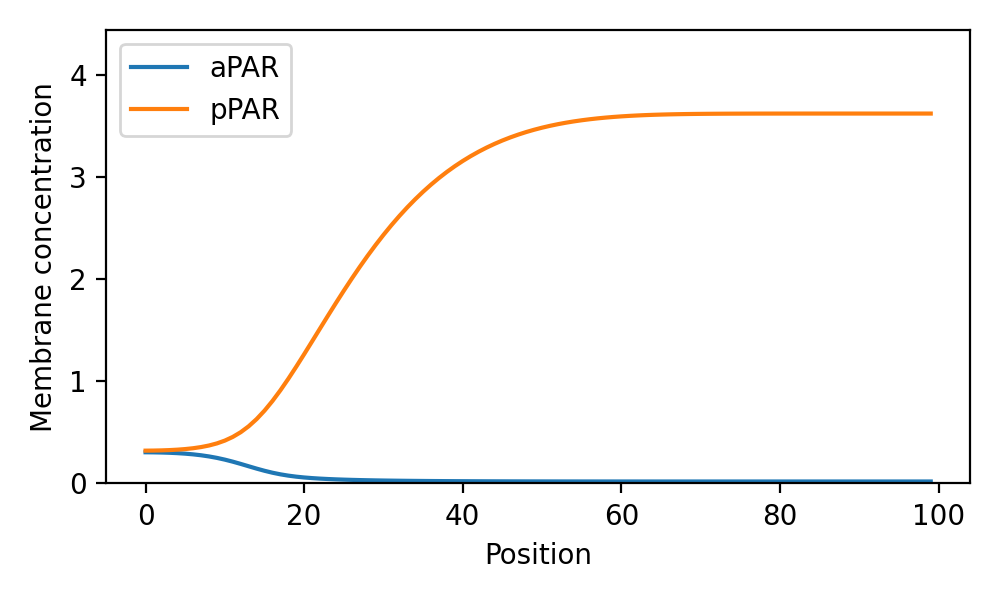

interactive(children=(FloatSlider(value=0.0, description='time', max=654.5066535941907, step=1.0), Output()), …

In [11]:
interactive_fig(solns2, times2)

## Saved models

This repository contains many predefined polarity PDEs, including the Goehring 2011 model (and various extended forms), wave-pinning model, GOR model and OT model. These can be found in models/pde.